In [1]:
import tensorflow as tf
print("TF VERSION:",tf.__version__)

TF VERSION: 2.1.0


In [2]:
#检查GPU是否支持GPU
print("gpu is","AVAILABLE" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

gpu is AVAILABLE


In [3]:
import numpy as np

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [4]:
#定义图像标准化函数
def normalize_image(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img,tf.uint8)

In [5]:
#定义图像可视化函数
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [6]:
#定义保存图像文件函数
def save_image(img,file_name):
    PIL.Image.fromarray(np.array(img)).save(file_name)

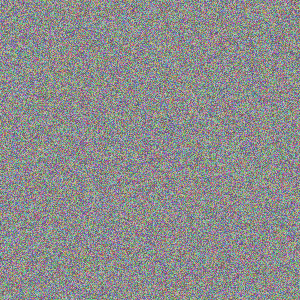

In [7]:

img_noise = np.random.uniform(size=(300,300,3)) + 100.0
img_noise = img_noise.astype(np.float32) #dtype转换成float32
show_image(normalize_image(img_noise))

In [8]:
#预训练模型的加载
base_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

In [9]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
#确定需要最大激活的卷积层
layer_names = ['mixed3','mixed5']

layers = [base_model.get_layer(name).output for name in layer_names]
layers

[<tf.Tensor 'mixed3/Identity:0' shape=(None, None, None, 768) dtype=float32>,
 <tf.Tensor 'mixed5/Identity:0' shape=(None, None, None, 768) dtype=float32>]

In [11]:
#创建特征提取模型
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [12]:
#查看模型摘要
dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
#损失计算
def calc_loss(img,model):
       
    #channels = [13,139] #选定第13通道
    
   # img = tf.expand_dims(img,axis = 0) #由（300，300，3）扩展为（1，300，300，3）
    
    #图像通过模型前向传播得到计算结果
   # layer_activations = model(img)
    
  #  losses= [] #计算选中每通道的计算结果均值
   # for cn in channels:
        
    #取选中通道的值
   #     act=layer_activations[:,:,:,cn]
    
    #选中通道的输出结果算均值
   #     loss=tf.math.reduce_mean(act)
    #    losses.append(loss)
    
    img = tf.expand_dims(img,axis=0)
    layer_activations = model(img)
    losses=[]
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
        
    return tf.reduce_sum(losses)

In [14]:
#定义图像优化过程
def render_deepdream(model,img,steps=100,step_size=0.01,verbose=1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            #对img精选梯度变换
            tape.watch(img)
            loss = calc_loss(img,model)
            
        #计算损失相对输入图像像素的梯度
        gradients = tape.gradient(loss,img)
        
        #归一化梯度值
        gradients /= tf.math.reduce_std(gradients)+1e-8
        
        #梯度上升中，损失zhi越来越大，因此可以直接添加到损失zhi的图像中。
        img = img +gradients*step_size
        img = tf.clip_by_value(img,-1,1)
        
        #输出过程显示提示信息
        if(verbose ==1):
            if((n+1)%10==0):
                print("Step {}/{},loss {}".format(n+1,steps,loss))
                
    return img

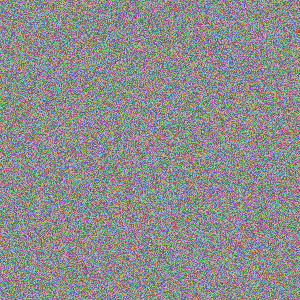

In [15]:
#实例
#img_noise = np.random.uniform(size=(300,300,3))+100.0
#img_noise = img_noise.astype(np.float32) #dtype 转换成float32
#show_image(normalize_image(img_noise))


def read_image(file_name,max_dim=None):
    image_path = "./zucc1.jpg"
    img= PIL.Image.open(file_name)
    
    if max_dim:
        img.thumbnail((max_dim,max_dim))
    return np.array(img)

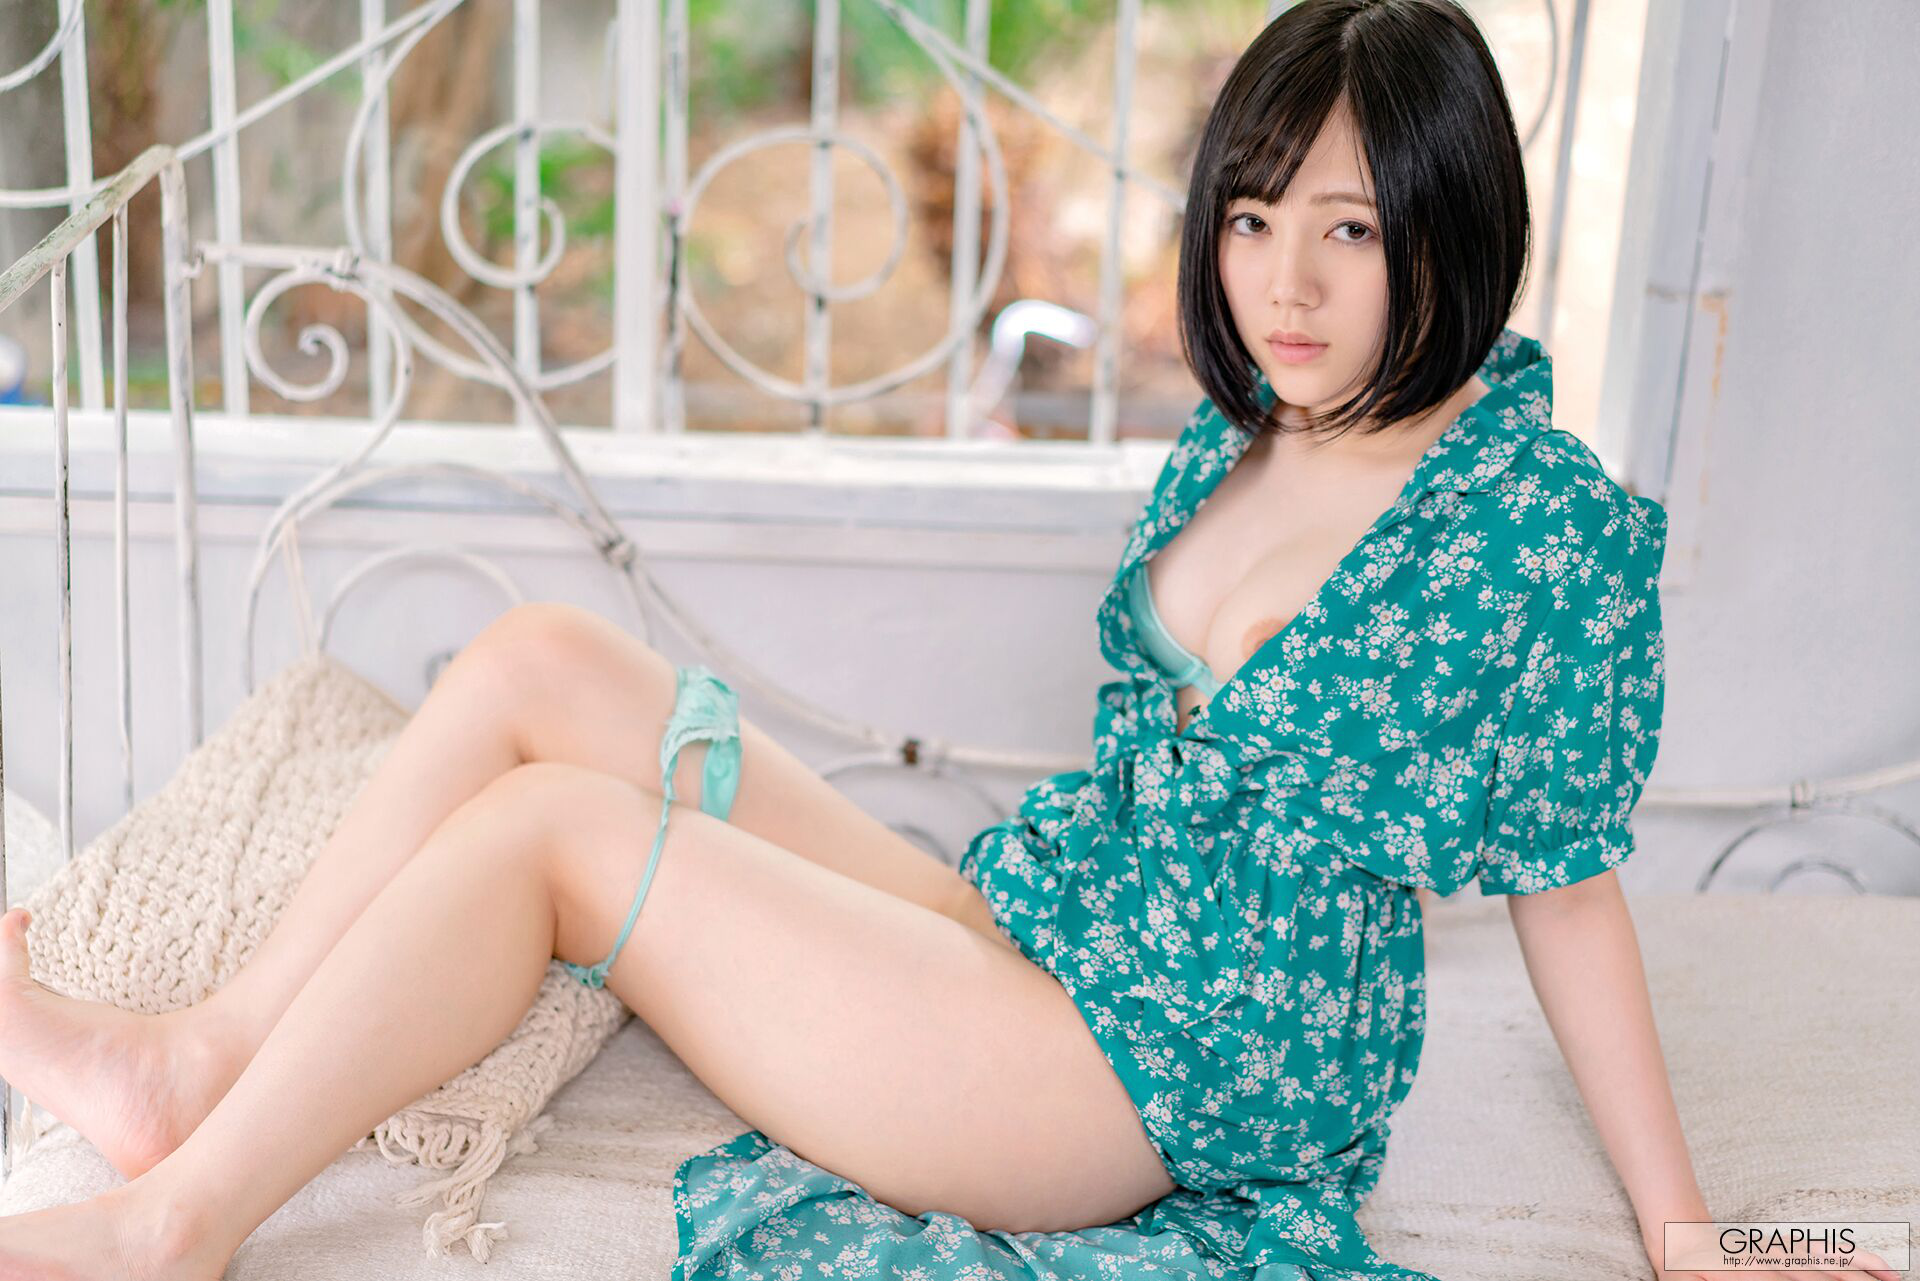

In [19]:
#读取待处理图像
image_file = "zucc1.jpg"

original_img = read_image(image_file,max_dim =2000)

show_image(original_img)

In [20]:
img = tf.keras.applications.inception_v3.preprocess_input(img_noise)
img = tf.convert_to_tensor(img)

starting
Step 10/100,loss 0.8893388509750366
Step 20/100,loss 1.184058427810669
Step 30/100,loss 1.405298113822937
Step 40/100,loss 1.5918279886245728
Step 50/100,loss 1.756700038909912
Step 60/100,loss 1.906482458114624
Step 70/100,loss 2.0389344692230225
Step 80/100,loss 2.1590890884399414
Step 90/100,loss 2.252110719680786
Step 100/100,loss 2.3438844680786133
wake up


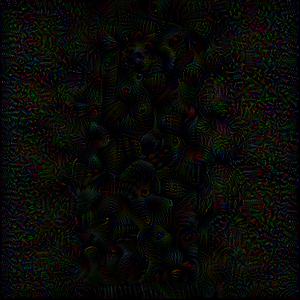

saved:ZUCC.jpg!


In [21]:
#应用Deep Dream
import time
start =time.time()
print("starting")

#调节优化过程
dream_img = render_deepdream(dream_model,img,steps=100,step_size=0.01)

end = time.time()
end-start
print("wake up")

#标准化图像
dream_img = normalize_image(dream_img)
#显示结果函数
show_image(dream_img)

#保存结果图像

file_name = 'ZUCC.jpg'.format(layer_names)
#file_name = 'deepdream_{}.jpg'.format(layer_names)
save_image(dream_img,file_name)
print("saved:{}!".format(file_name))


In [ ]:
def read_image(file_name,max_dim=None):
    image_path = "./ZUCC.jpg"
    img= PIL.Image.open(file_name)
    
    if max_dim:
        img.thumbnail((max_dim,max_dim))
    return np.array(img)

In [ ]:
#读取待处理图像
image_file = "ZUCC.jpg"

original_img = read_image(image_file,max_dim =2000)

show_image(original_img)